# Identificador de partes de casa

### Proposito

Identificar cada cômodo da casa


### Passo 1: Baixar imagens modelo de possíveis casos de uso

In [1]:
! pip install -Uqq fastai fastbook duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('house image', max_images=1)
urls[0]

'https://ansunibaate.com/wp-content/uploads/2019/05/luxury-home-wallpaper-House-Images-HD-Photos-Gallery-Download.jpg'

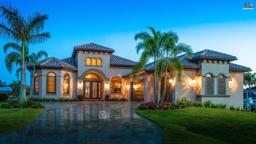

In [4]:
from fastdownload import download_url
dest = 'house.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

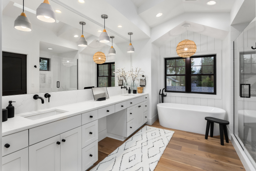

In [5]:
download_url(search_images('Bathroom photos', max_images=1)[0], 'Bathroom.jpg', show_progress=False)
Image.open('Bathroom.jpg').to_thumb(256,256)

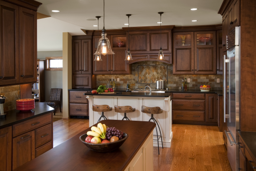

In [6]:
download_url(search_images('kitchen photos', max_images=1)[0], 'kitchen.jpg', show_progress=False)
Image.open('kitchen.jpg').to_thumb(256,256)

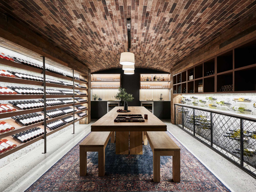

In [7]:
download_url(search_images('Cellar photos', max_images=1)[0], 'Cellar.jpg', show_progress=False)
Image.open('Cellar.jpg').to_thumb(256,256)

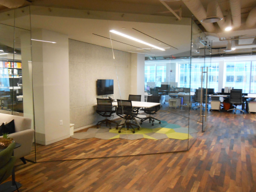

In [8]:
download_url(search_images('office photos', max_images=1)[0], 'office.jpg', show_progress=False)
Image.open('office.jpg').to_thumb(256,256)

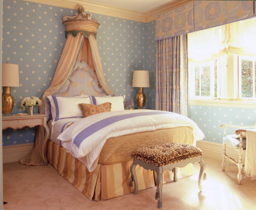

In [9]:
download_url(search_images('Bedroom photos', max_images=1)[0], 'Bedroom.jpg', show_progress=False)
Image.open('Bedroom.jpg').to_thumb(256,256)

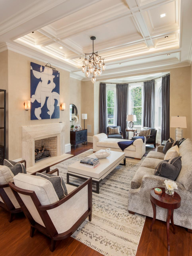

In [10]:
download_url(search_images('Living room photos', max_images=1)[0], 'Livingroom.jpg', show_progress=False)
Image.open('Livingroom.jpg').to_thumb(256,256)

In [11]:
part_house = 'house','Bathroom','kitchen','Cellar','office','Bedroom','living room'
path = Path('part_house')

from time import sleep

for o in part_house:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} house photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Passo 2: Treinar o modelo

### Remover as fotos que vieram com erros de download

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

25

Dataloaders são objetos que contem uma configuração de treino, usando a validação para julgar quanto um modelo pode ser confiável

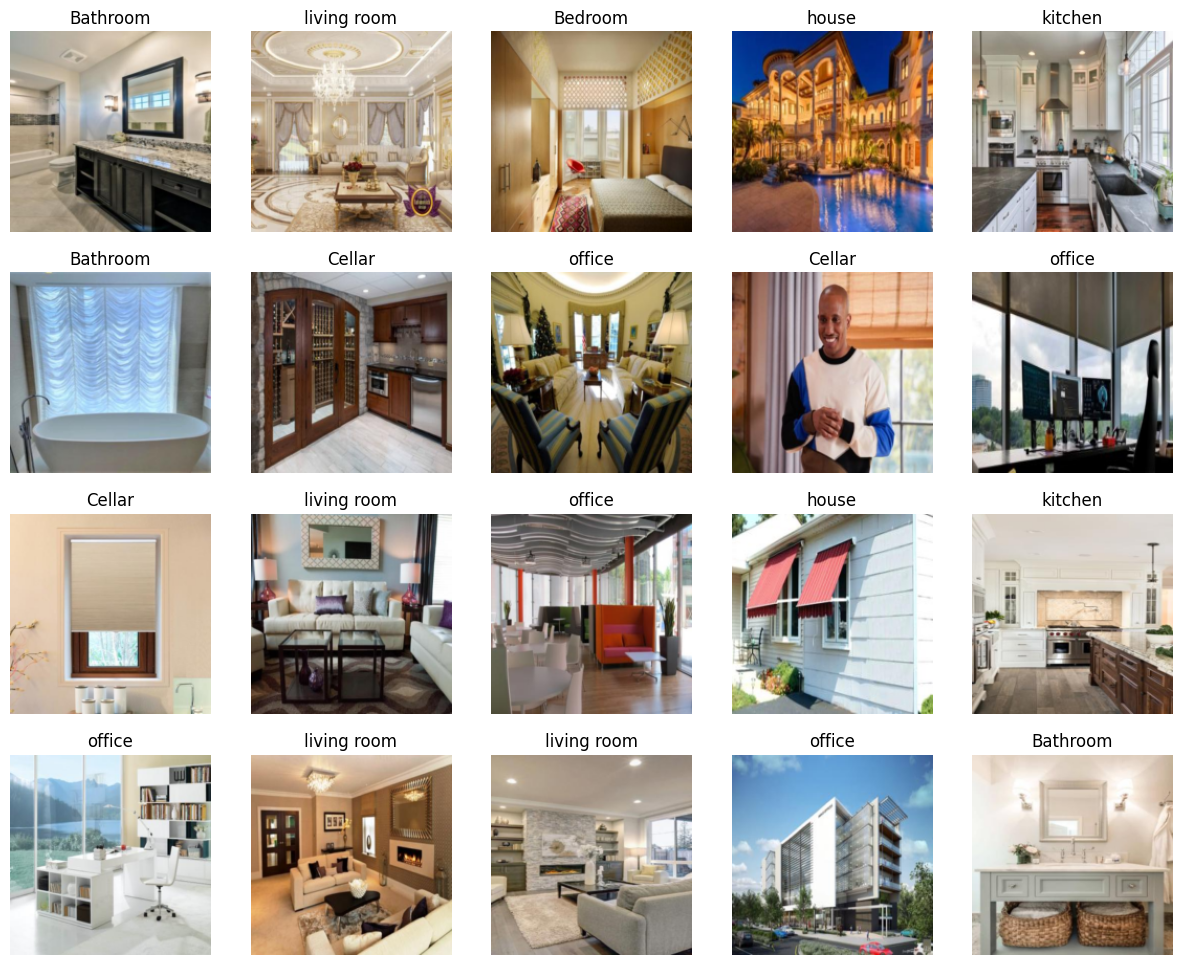

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.842512,0.977347,0.292553,02:30


epoch,train_loss,valid_loss,error_rate,time
0,0.881332,0.736888,0.224734,03:16
1,0.519807,0.693129,0.199468,03:15
2,0.276938,0.681876,0.183511,03:43


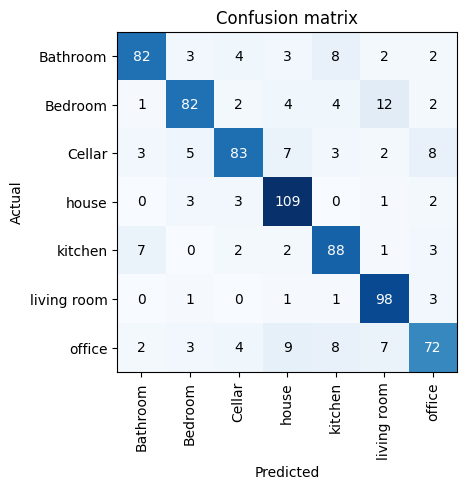

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

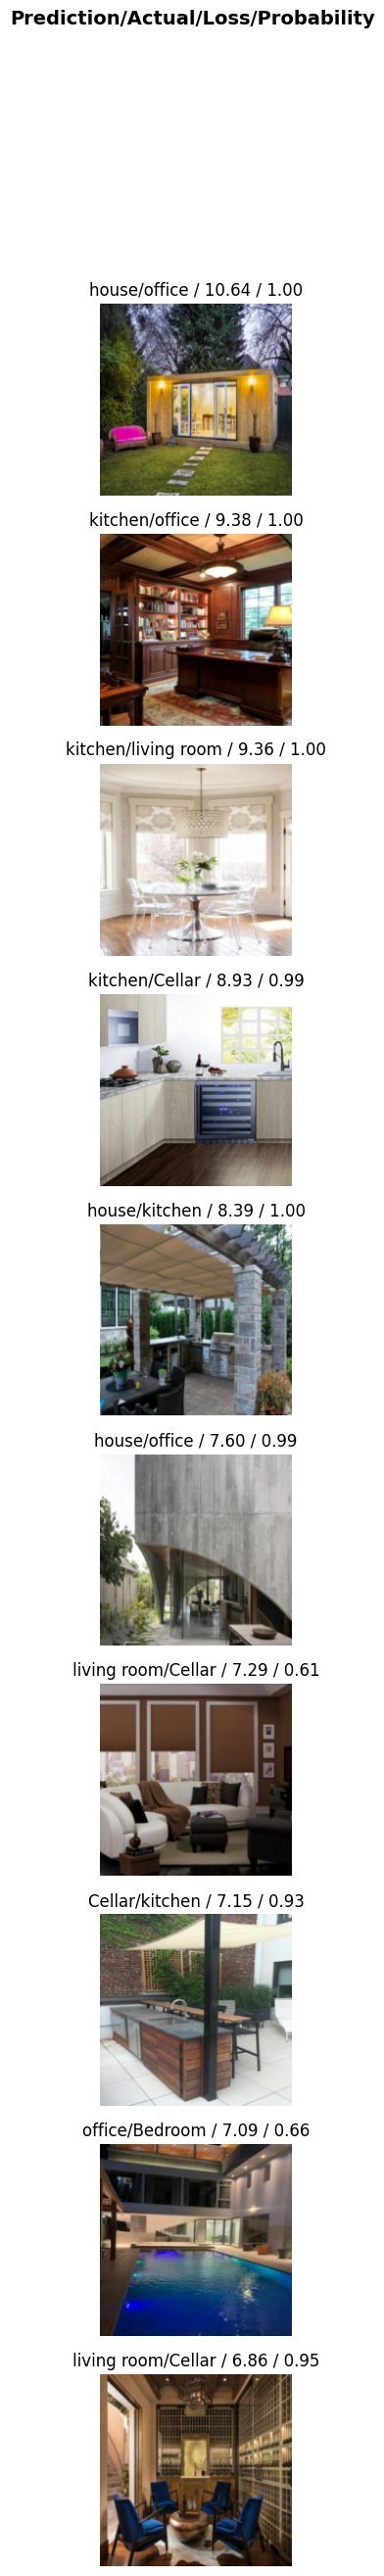

In [16]:
interp.plot_top_losses(10, nrows=10)

## O momento da escolha de imagem

- the x axis shows how many seconds it takes to process one image (**note**: it's a log scale)
- the y axis is the accuracy on Imagenet
- the size of each bubble is proportional to the size of images used in testing
- the color shows what "family" the architecture is from.

In [17]:
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

c:\Users\muril\OneDrive\Área de Trabalho\house_detector\pytorch-image-models\results


Cloning into 'pytorch-image-models'...
Updating files:  51% (250/482)
Updating files:  52% (251/482)
Updating files:  53% (256/482)
Updating files:  54% (261/482)
Updating files:  55% (266/482)
Updating files:  56% (270/482)
Updating files:  57% (275/482)
Updating files:  58% (280/482)
Updating files:  59% (285/482)
Updating files:  60% (290/482)
Updating files:  61% (295/482)
Updating files:  62% (299/482)
Updating files:  63% (304/482)
Updating files:  64% (309/482)
Updating files:  65% (314/482)
Updating files:  66% (319/482)
Updating files:  67% (323/482)
Updating files:  68% (328/482)
Updating files:  69% (333/482)
Updating files:  70% (338/482)
Updating files:  71% (343/482)
Updating files:  72% (348/482)
Updating files:  73% (352/482)
Updating files:  74% (357/482)
Updating files:  75% (362/482)
Updating files:  76% (367/482)
Updating files:  77% (372/482)
Updating files:  78% (376/482)
Updating files:  79% (381/482)
Updating files:  80% (386/482)
Updating files:  81% (391/482)


In [18]:
import pandas as pd
df_results = pd.read_csv('results-imagenet.csv')

In [19]:
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg')]

In [20]:
df = get_data('infer', 'infer_samples_per_sec')

In [21]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

In [22]:
show_all(df, 'Inference', 'infer_img_size')

In [23]:
! pip install timm

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pip\_internal\utils\logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pip\_vendor\rich\console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pip\_vendor\rich\console.py", line 1305, in render
    for render_output in iter_render:
  File "C:\Users\muril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\pip\_internal\utils\logging.py", line 134, in _

#### torch>=1.7
#### timm  0.6.12

![resultado resnet34](resnet34.jpg)

![Erro do banheiro resnet34](errorbathresnet34.jpg)

![resultado DR house](errohouseresnet34.jpg)

### regnet_x_16gf = crash

### vgg11 = crash

### levit = falha em baixar versão compatível

### crossvit = crash



# Conclusão

A família resnet foi a que melhor funcionou, e especificamente o resnet18 entregou uma menor porcentagem de erro